In [1]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from collections import deque
from torch.autograd import Variable

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env = gym.make('LunarLanderContinuous-v2')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action_space:', env.action_space)
print(' -low:', env.action_space.low)
print(' -high:',env.action_space.high)

class agent(nn.Module):
    def __init__(self,env,h_size = 16):
        super(agent, self).__init__()
        self.env = env
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
#         self.a_size = env.action_space.shape[0]
        self.a_size = 4
        
        self.lin1 = nn.Linear(self.s_size,self.h_size)
        self.lin2 = nn.Linear(self.h_size,self.a_size)
        
    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = F.tanh(self.lin2(x))
        return x.cpu().data
    
    def get_weight_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size + 1)*self.a_size
    
    def set_weights(self,weights):
        lin1_w = torch.from_numpy(weights[:self.s_size*self.h_size].reshape(self.h_size,self.s_size))
        lin1_b = torch.from_numpy(weights[self.s_size*self.h_size:self.s_size*self.h_size + self.h_size])
        lin2_w = torch.from_numpy(weights[(self.s_size+1)*self.h_size:(self.s_size+1)*self.h_size+self.h_size*self.a_size].reshape(self.a_size,self.h_size))
        lin2_b = torch.from_numpy(weights[-self.a_size:])
        
        self.lin1.weight.data.copy_(lin1_w.view_as(self.lin1.weight.data))
        self.lin2.weight.data.copy_(lin2_w.view_as(self.lin2.weight.data))
        self.lin1.bias.data.copy_(lin1_b.view_as(self.lin1.bias.data))
        self.lin2.bias.data.copy_(lin2_b.view_as(self.lin2.bias.data))
        
        
    def evaluate(self,weights,gamma,max_t):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            next_state, reward , done , info = env.step(action.numpy())
            episode_return += reward*math.pow(gamma,t)
            state = next_state
            if done:
                break
        return episode_return
    
agent = agent(env).to(device)

observation space: Box(8,)
action_space: Box(2,)
 -low: [-1. -1.]
 -high: [1. 1.]


/home/satya/anaconda3/envs/drlnd/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 10	Average Score: -177.72
Episode 20	Average Score: -139.09
Episode 30	Average Score: -122.53
Episode 40	Average Score: -87.72
Episode 50	Average Score: -35.41
Episode 60	Average Score: 5.61
Episode 70	Average Score: 36.94
Episode 80	Average Score: 60.66
Episode 90	Average Score: 82.70
Episode 100	Average Score: 100.38
Episode 110	Average Score: 144.88
Environment Solved in 12 iterations!	 Average_score : 152.57


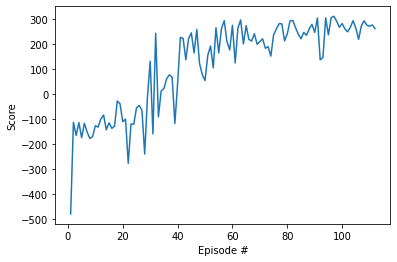

In [15]:
def cem(n_iterations = 500, max_t = 1000, gamma = 1.0, print_every = 10, pop_size=50, elite_frac=0.2, sigma = 0.5):
    n_elite = int(pop_size*elite_frac)
    
    scores_deque = deque(maxlen=100)
    score = []
    best_weights = sigma*np.random.randn(agent.get_weight_dim())
    
    for i_iteration in range(1,n_iterations+1):
        weights_pop = [best_weights + (sigma*np.random.randn(agent.get_weight_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights,gamma,max_t) for weights in weights_pop])
        
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weights = np.array(elite_weights).mean(axis = 0)
        
        reward = agent.evaluate(best_weights,gamma,max_t)
        scores_deque.append(reward)
        score.append(reward)
        
        torch.save(agent.state_dict(),'cem-lunarlander-continuous.pth')
        
        if i_iteration%print_every==0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration,np.mean(scores_deque)))
        if np.mean(scores_deque)>=150.0:
            print('Environment Solved in {:d} iterations!\t Average_score : {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return score

scores = cem()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1,len(scores)+1),scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [5]:
agent.load_state_dict(torch.load('cem-lunarlander-continuous.pth'))
# env = gym.wrappers.Monitor(gym.make('LunarLanderContinuous-v2'), './video/',video_callable=lambda episode_id: True,force = True)
state = env.reset()

while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state,reward,done,_ = env.step(action.numpy())
    state = next_state
    if done:
        break
env.close()